In [1]:
import numpy as np
import os
import pandas as pd
import yfinance as yf
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas_market_calendars as mcal

from model import fetchStockData, buildLookbackData, buildTensorData, buildRNN, plotPrediction, plotPredictionTest

tf.random.set_seed(13)

In [2]:
df = fetchStockData('AAPl', '2011-01-01', '2020-03-01')

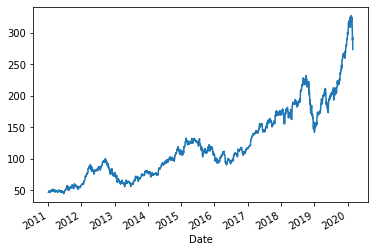

In [3]:
# Plot daily prices of AAPL
df['Close'].plot()

In [4]:
# Use 80% for training data
TRAIN_SPLIT = int(len(df) * 0.8)

# n day lookback
LOOKBACK = 45
# n day prediction
TARGET = 10
# n value batch
BATCH_SIZE = 25

# buffer - for shuffling, so memory doesnt overflow
BUFFER_SIZE = 10000

# For training
EVALS = 200
EPOCHS = 10

In [5]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [6]:
# Scale data
# Scale the data
df_features = df[['Close', 'Volume']]
scaled = (df_features-df_features.mean())/df_features.std()
scaled_values = scaled.values

# For later re-conversion
MEAN = df_features.mean()['Close']
STD = df_features.std()['Close']
MEAN_V = df_features.mean()['Volume']
STD_V = df_features.std()['Volume']

### Split Train and Test Data

In [7]:
x_train, y_train = buildLookbackData(scaled_values, 
                                     target = scaled_values[:, 0], 
                                     start_index = 0,
                                     end_index = TRAIN_SPLIT, 
                                     lookback = LOOKBACK,
                                     target_size = TARGET)

x_test, y_test = buildLookbackData(scaled_values, 
                                   target = scaled_values[:, 0],
                                   start_index = TRAIN_SPLIT, 
                                   end_index = None, 
                                   lookback = LOOKBACK,
                                   target_size = TARGET)

### Put Data Into Tensors

In [8]:
train_data, test_data = buildTensorData(x_train, y_train, x_test, y_test, BATCH_SIZE, BUFFER_SIZE)

### Build Model

In [9]:
model = buildRNN((LOOKBACK, 2), 250, 50, TARGET)

### Train Model

In [10]:
training_history = model.fit(train_data, 
                             epochs = EPOCHS,
                             steps_per_epoch = EVALS,
                             validation_data = test_data,
                             validation_steps = 50)

Epoch 1/10
200/200 [==============================] - 26s 132ms/step - loss: 0.1604 - val_loss: 0.5684
Epoch 2/10
200/200 [==============================] - 27s 136ms/step - loss: 0.0848 - val_loss: 0.3466
Epoch 3/10
200/200 [==============================] - 28s 139ms/step - loss: 0.0718 - val_loss: 0.3961
Epoch 4/10
200/200 [==============================] - 28s 138ms/step - loss: 0.0647 - val_loss: 0.4272
Epoch 5/10
200/200 [==============================] - 28s 141ms/step - loss: 0.0611 - val_loss: 0.4531
Epoch 6/10
200/200 [==============================] - 28s 140ms/step - loss: 0.0579 - val_loss: 0.4627
Epoch 7/10
200/200 [==============================] - 28s 141ms/step - loss: 0.0555 - val_loss: 0.5620
Epoch 8/10
200/200 [==============================] - 26s 128ms/step - loss: 0.0532 - val_loss: 0.6312
Epoch 9/10
200/200 [==============================] - 14s 70ms/step - loss: 0.0505 - val_loss: 0.6130
Epoch 10/10
200/200 [==============================] - 9s 44ms/step - loss

### Allow an arbitrary period of data

In [11]:
# Add in new data, not part of training/testing
df_new = fetchStockData('AAPL', '2020-03-01', '2020-05-12')[['Close', 'Volume']]
scaled_new = df_new.copy()
scaled_new['Close'] = (df_new['Close'] - MEAN) / STD
scaled_new['Volume'] = (df_new['Volume'] - MEAN_V) / STD_V

df_new = pd.concat([df[['Close', 'Volume']], df_new])
scaled_new = pd.concat([scaled, scaled_new])

<Figure size 432x288 with 0 Axes>

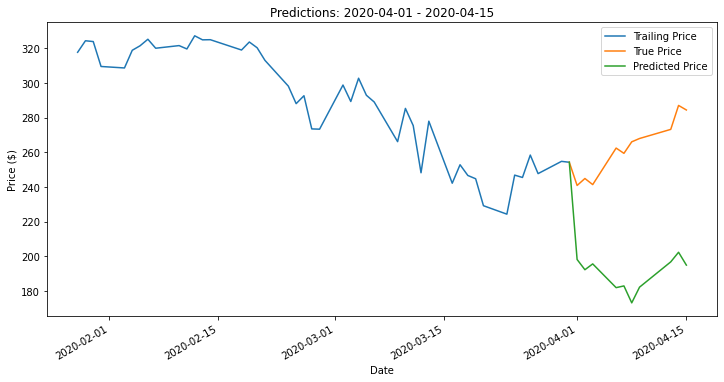

<Figure size 432x288 with 0 Axes>

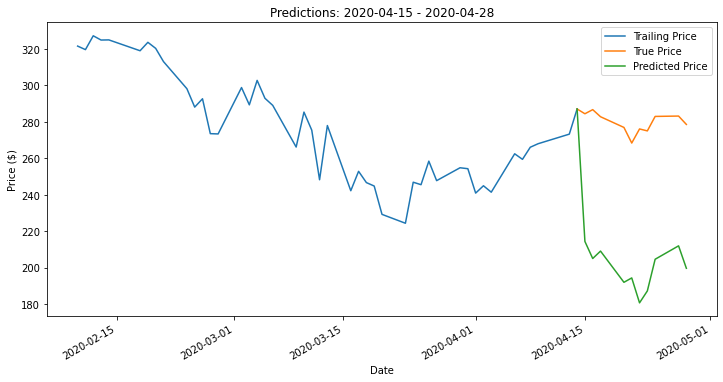

<Figure size 432x288 with 0 Axes>

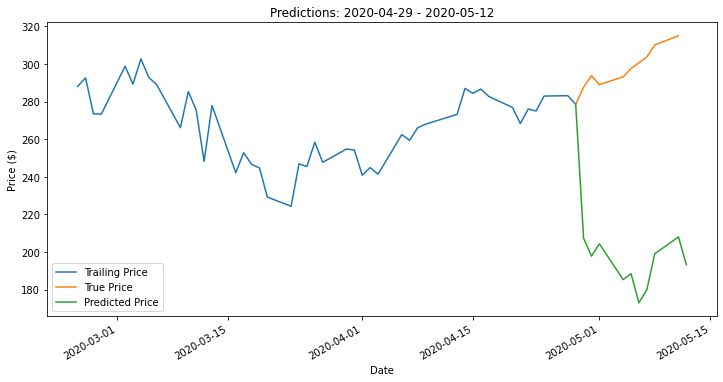

<Figure size 432x288 with 0 Axes>

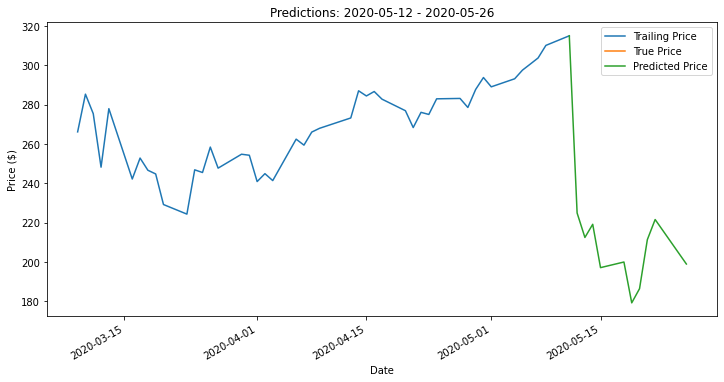

In [12]:
joined, predicted = plotPrediction(model, df_new, scaled_new, np.datetime64('2020-04-01'), 
                                   LOOKBACK, TARGET, MEAN, STD, instrument='Equity')

joined, predicted = plotPrediction(model, df_new, scaled_new, np.datetime64('2020-04-15'), 
                                   LOOKBACK, TARGET, MEAN, STD, instrument='Equity')

joined, predicted = plotPrediction(model, df_new, scaled_new, np.datetime64('2020-04-29'), 
                                   LOOKBACK, TARGET, MEAN, STD, instrument='Equity')

joined, predicted = plotPrediction(model, df_new, scaled_new, np.datetime64('2020-05-12'), 
                                   LOOKBACK, TARGET, MEAN, STD, instrument='Equity')